In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import  keras

import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brijesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df1 = pd.read_csv("./datasets/yt.csv",delimiter=',')
df2 = pd.read_csv("datasets/spam-model.csv",delimiter=',')
df3 = pd.read_csv("datasets/spam-or-not.csv",delimiter=',')
df4 = pd.read_csv("datasets/sms.csv",delimiter=',')

df = pd.concat([df1,df2,df3,df4])


df = df[["Comment", "Spam"]]

df = df.drop_duplicates()
df = df.dropna()

df["Comment"] = df["Comment"].map(lambda  text :  re.compile("\"").sub("", text) )
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"https?://\S+|www\.\S+").sub(r"[URL]", text) )
df["Comment"] = df["Comment"].map(lambda  text :  text.translate(str.maketrans("", "", string.punctuation)))
df["Comment"] = df["Comment"].map(lambda  text :  " ".join([word.lower() for word in text.split() if word.lower() not in set(stopwords.words("english"))]) )


In [7]:
random = RandomOverSampler()
X , y =  random.fit_resample(df["Comment"].values.reshape(-1, 1),df["Spam"].values)

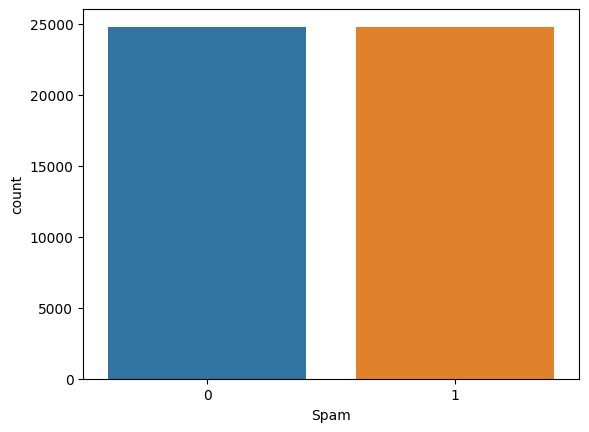

In [8]:
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df.columns)

sns.countplot(x="Spam",data=transformed_df)
data=df

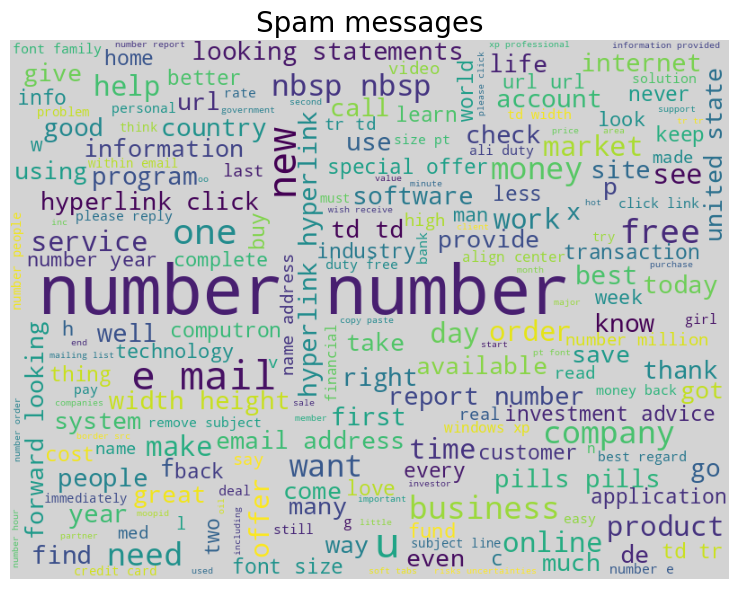

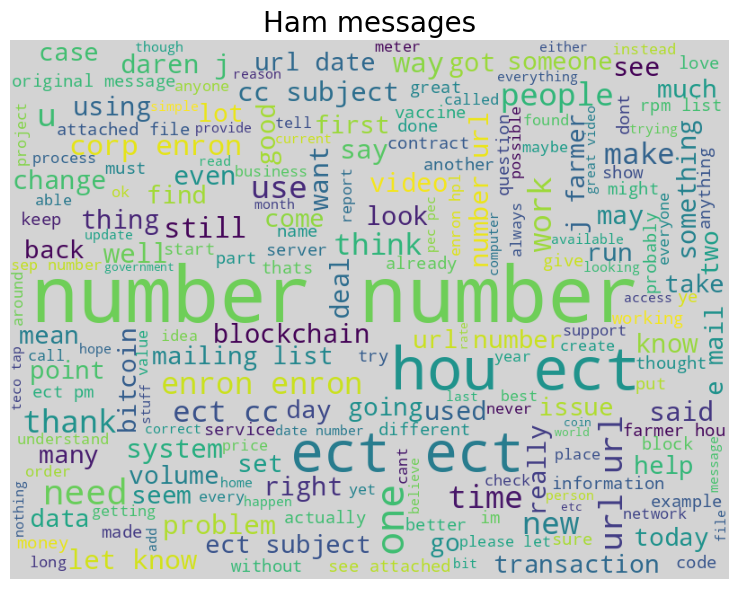

In [9]:
data_ham  = data[data['Spam'] == 0].copy()
data_spam = data[data['Spam'] == 1].copy()

def show_wordcloud(df, title):
    text = ' '.join(df['Comment'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()
show_wordcloud(data_spam, "Spam messages")
show_wordcloud(data_ham, "Ham messages")

In [10]:
# X = df['Comment'].values
# Y = df['Spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:

# model = "https://tfhub.dev/google/nnlm-en-dim50/2"
# hub_layer = hub.KerasLayer(model,input_shape=[], dtype=tf.string, trainable=True)
nnlm_model = tf.saved_model.load("./models/nnlm-en-dim50_2")

model = tf.keras.Sequential([
    hub.KerasLayer(nnlm_model,input_shape=[], dtype=tf.string,trainable=True),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build()
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
print(model.summary())

2023-04-26 13:41:50.886111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-26 13:41:54.513291: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-26 13:41:55.835307: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192762400 exceeds 10% of free system memory.
2023-04-26 13:42:01.871035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start abo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 150)               7650      
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 48,218,451
Trainable params: 48,218,451
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# model = tf.keras.models.load_model('./trained-model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

OSError: No file or directory found at ./trained-model.h5

In [13]:

# fit the model
model.fit(X_train,
         y_train,
         epochs=10,
         batch_size=512,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=10)]
)


tf.saved_model.save(model, "fine_tuned")
model.save("trained-model.h5",include_optimizer=True)

Epoch 1/10
30/78 [==========>...................] - ETA: 39s - loss: 0.0049 - accuracy: 0.9989

KeyboardInterrupt: 

In [46]:
# model_prod = tf.keras.models.load_model('./trained-model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model.evaluate(X_test,y_test)

181/181 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.9875


[0.05808057263493538, 0.9875021576881409]

In [50]:
sms = [
    # Seen before
    "That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸",
    
    # New spam
    "I'm so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I'm so happy because his trusted and reliable"
    "This is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.",
    "I recommend y'all to Doavercracks on IG.",
    "BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to end the bull run towards mid year, investor's and trader's find it difficult to decide how best to utilize the current market, holding is profitable but trading is far more profitable, I was able to grasp knowledge of trading crypto assets earlier enough, I didn't think it was possible to make constant win from trading till I come across Mrs milly program for investor's and newbies who lack understanding on how trading BTC works, to help them stack up more bitcoin, since late last year till date I have made over 19BTC from 2.6BTC with Mrs milly's help, you can easily get to her with this WhatsApp number +1-2-1-0-8-0-6-4-8-8-9",
    "Never thought it was possible to recover my lost btc until I meet victoolz on insta who helped me...",
    "Can't recommend him enough for his tireless effort and tremendous job done Doavercracks on IG his truly the best 💯💯",
    "Good channel in teleg TAKEPROFITPLAN . Lots of cool ideas for free. Check ...",
    
    # Not spam
    "Amazing video!",
    "Maybe to make proof of stake system more democraric we can think about share a certain amount of money the validator get to all the other validators?",
    "I don't get it 😅😂",
    
    # Made up spam (definitely not seen before)
    "Xavier is wonderful, I traded with him and made huge profits",
    "Contact Mr. Decuyper for advice"

]
model.evaluate(sms,[1,1,1,1,1,1,1,0,0,0,1,1])
# for test in sms:
#     out = model.predict([test])
#     print("%s - %f - %s" % ("Spam" if out[0] > 0.5 else "HAM", out[0], test))
#     print()

1/1 [==============================] - 0s 190ms/step - loss: 6.9716 - accuracy: 0.4167


[6.9716010093688965, 0.4166666567325592]

In [ ]:
model_prod = tf.keras.models.load_model('./trained-model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
text = input("text")

out = model_prod.predict([test]) > 0.9
print("%s - %f - %s" % ("Spam" if out[0] > 0.5 else "not spam", out[0], test))


user = int(input("is coorect"))

if not user :
    print("d")
    model.fit([text],
            [not out],
            epochs=2,
            batch_size=512,
            # validation_data=(X_test, y_test),
            verbose=1,
            # callbacks=[early_stop]
    )
    tf.saved_model.save(loaded_obj, "fine_tuned")
    model.save("model", include_optimizer=False)
    model.save("trained-model.h5")

2023-04-16 20:07:26.064419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 20:07:26.064926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-16 20:07:26.065024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-16 20:07:26.065099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-16 20:07:26.065173: W tensorflow/c

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


ValueError: Layer count mismatch when loading weights from file. Model expected 3 layers, found 2 saved layers.

# https://www.kaggle.com/code/ishansoni/sms-spam-collection-dataset
## https://www.kaggle.com/code/dejavu23/sms-spam-or-ham-beginner
# https://www.kaggle.com/code/mfaisalqureshi/email-spam-detection-98-accuracy

''

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import tensorflow as tf


model = Model(inputs=input1, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])

tf.saved_model.save(loaded_obj, "fine_tuned")
model.save("model.h5", include_optimizer=False)




model = Model(inputs=input1, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])

tf.saved_model.save(loaded_obj, "fine_tuned")
model.save("model", include_optimizer=False)
